# Zero-Shot Classification using CLAP Models

Embeddings used in these experiments are extracted in the extract_embeddings.ipynb notebook. Each experiment is executed on MSCLAP and LAION CLAP.

Experiments:
1. k-fold evaluation. Accuracy and average precision is reported. The results for each fold are averaged over 1k calculations. The experiment is repeated with and without overlapping samples between folds, comprising 200 and 17 folds respectively. 
2. Consolidate classes.

In [28]:
from msclap import CLAP
import laion_clap
import json
import pandas as pd
from dataset import DatasetUCS
import torch
import matplotlib.pyplot as plt
import configs.graphics_settings as graphics_settings
import random
import IPython.display as ipd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, average_precision_score, ConfusionMatrixDisplay
import os
import numpy as np
from tqdm import tqdm

In [194]:
# Load Testing Set
with open ('configs/zero-shot.json', 'r') as f:
    settings = json.load (f)

# Load USC Classes
with open ('data/ucs_official/ucs_classes.json', 'r') as f:
    ucs_classes = json.load (f)

In [19]:
# Load models
msclap_model = CLAP(version = '2023', use_cuda=False) # version can be 2022 or 2023
laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
laion_clap_model.load_ckpt()

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.we

In [143]:
def k_fold_zs_evaluation(audio_embeddings:torch.Tensor, ground_truth_path:str, text_encoding_func, similarity_func, max_samples:int=None):
    """
    This function evaluates pytorch audio embeddings on zero-shot classification.

    Args:
    - audio_embeddings: extracted pytorch embeddings, shape (batch_size, n_classes, latent_dim). Indeces must correspond to the ground truth csv.
    - ground_truth_path: path to directory containing csv files, one for each fold
    - text_encoding_func: the function to use to extract text embeddings
    - similarity_func: function to be used to compute similarity. Must take two sets of embeddings as input.
    - k_folds: must be equal or less than the number of folds
    - max_samples: slices the audio embeddings and ground truth csvs. Used for sanity checks.
    """
    from sklearn.metrics import accuracy_score, average_precision_score
    from tqdm import tqdm

    fold_csv_list = [file for file in os.listdir(ground_truth_path)]

    total_acc = 0
    total_ap = 0
    all_predictions = []
    all_gold_labels = []
    for (true_fold, pred_fold) in tqdm(zip(fold_csv_list, audio_embeddings), total=len(fold_csv_list)):
        # Load fold from csv, used to compare class 
        df = pd.read_csv(ground_truth_path + true_fold)
        dataset = DatasetUCS(df, settings, device='cpu', return_type='path')
        label_embeddings = text_encoding_func(dataset.get_unique_classes()).cpu()

        pred = []
        true = []
        for i in tqdm(range(len(dataset)), leave=False):
            _, _, class_name = dataset[i] # gold label
            
            current_emb = pred_fold[i].cpu()
            similarities = similarity_func(current_emb, label_embeddings)
            similarities = similarities.detach()
            probs = torch.softmax(similarities.unsqueeze(0), dim=1).detach().flatten() * 100
            idx = torch.argmax(probs)
            pred.append(idx.item())
            true.append(ucs_classes['class_to_int'][class_name])
            #indeces = torch.topk(probs, k=3).indices
            
        accuracy = accuracy_score(true, pred)
        total_acc += accuracy
        ap = average_precision_score(np.array(true).reshape(-1, 1), np.array(pred).reshape(-1, 1))
        total_ap += ap
        all_predictions.append(pred)
        all_gold_labels.append(true)

    mean_acc = total_acc / len(fold_csv_list)
    mean_ap = total_ap / len(fold_csv_list)
    return mean_acc, mean_ap, all_predictions, all_gold_labels
    

def load_embeddings_from_disk(dir_path:str):
    """
    Loads a list of torch embeddings and concatenates them along the first dimension. Output shape: (n_embeddings, (x.shape))

    Args:
    - dir_path: path to a directory containing pytorch embeddings. These embeddings must be of the same shape.
    """
    audio_embeddings = None
    for file in os.listdir(dir_path):
        if (audio_embeddings != None):
            audio_embeddings = torch.cat((audio_embeddings, torch.load(dir_path + file).unsqueeze(0)), dim=0)
        else:
            audio_embeddings = torch.load(dir_path + file).unsqueeze(0)

    return audio_embeddings

In [144]:
k_fold_200_audio_embeddings_laion = load_embeddings_from_disk(settings["k_fold_200-laion_audio_embeddings"])
k_fold_200_audio_embeddings_msclap = load_embeddings_from_disk(settings["k_fold_200-msclap_audio_embeddings"])
k_fold_17_audio_embeddings_laion = load_embeddings_from_disk(settings["k_fold_17-laion_audio_embeddings"]) 
k_fold_17_audio_embeddings_msclap = load_embeddings_from_disk(settings["k_fold_17-msclap_audio_embeddings"])

## MS CLAP
This section evaluates MSCLAP on Soundly-80k through the following metrics: Precision, Recall, Mean Average Precision

Predicted Class (Best Prediction): crowds
Predicted Classes (Best Match To Worst): crowds, archived, voices
True Class: crowds


<BarContainer object of 81 artists>

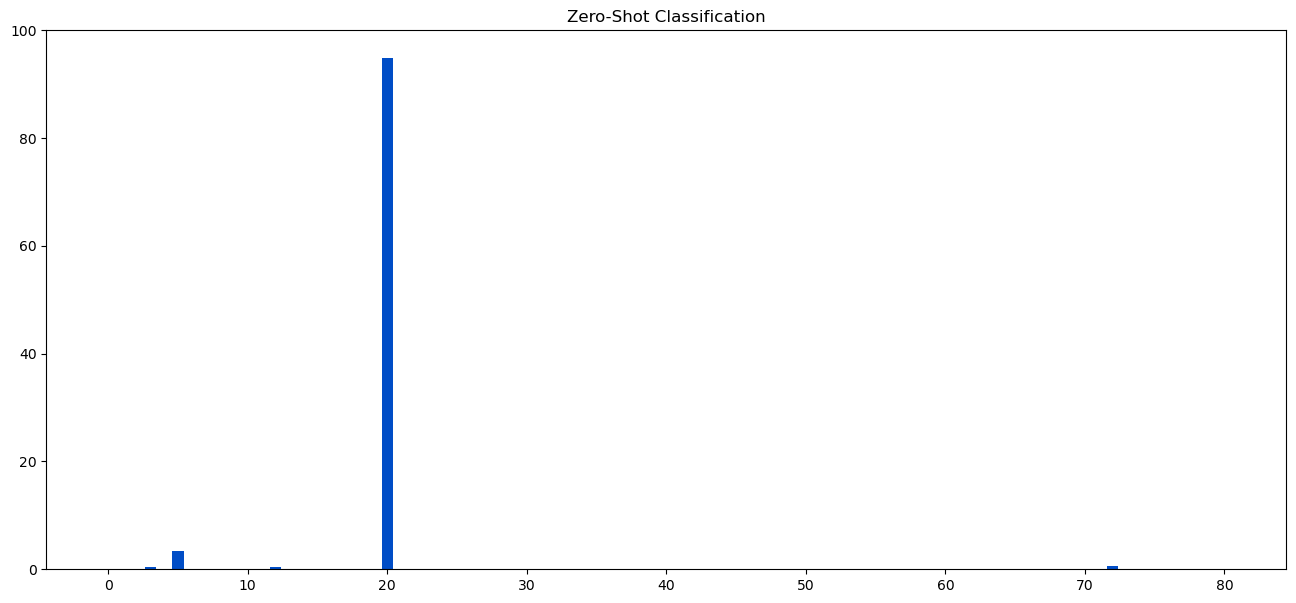

In [147]:
# This block outlines the process we go through for evaluation.

k_fold_embeddings = k_fold_17_audio_embeddings_msclap
# Sample randomly from the dataset. 
fold_idx = random.randint(0, k_fold_embeddings.size()[0]-1)
sample_idx = random.randint(0, k_fold_embeddings.size()[1]-1)

df = pd.read_csv(settings["k_fold_200-ground_truth"] + f"zs_fold_{fold_idx+1}.csv")
dataset = DatasetUCS(df, settings, device='cpu', return_type='path')
path, label, class_name = dataset[sample_idx]
# Extract
#dataset_audio_embeddings = torch.load(settings['dataset_drive'] + settings['msclap_emb_path'])
label_embeddings = msclap_model.get_text_embeddings(dataset.get_unique_classes())
audio_embeddings = k_fold_embeddings[fold_idx][sample_idx].cpu()
similarities = msclap_model.compute_similarity(audio_embeddings, label_embeddings)
#similarities = torch.cosine_similarity(audio_embeddings, label_embeddings)
similarities = similarities.detach()

# Logits -> Probabilities, report prediction and ground truth.
probs = torch.softmax(similarities.view(-1, 1), dim=0).detach().flatten() * 100
idx = torch.argmax(probs)
print(f"Predicted Class (Best Prediction): {dataset.get_unique_classes()[idx]}")
indeces = torch.topk(probs, k=3).indices
print(f"Predicted Classes (Best Match To Worst): {dataset.get_unique_classes()[indeces[0]]}, {dataset.get_unique_classes()[indeces[1]]}, {dataset.get_unique_classes()[indeces[2]]}")
print(f"True Class: {class_name}")

# Plot probabilities
fig = plt.figure(2, figsize=(16, 7))
ax = fig.subplots(1)
ax.set_title("Zero-Shot Classification")
ax.set_ylim(0, 100)
ax.bar(range(len(probs)), height=probs, color=graphics_settings.primary_color)

# K-Fold Zero Shot Classification



In [150]:
k_fold_17_mean_acc, k_fold_17_mean_ap, k_fold_17_pred, k_fold_17_true = k_fold_zs_evaluation(k_fold_17_audio_embeddings_msclap, settings['k_fold_17-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)
k_fold_17_gold_labels = np.array(k_fold_17_true).flatten()
k_fold_17_pred_labels = np.array(k_fold_17_pred).flatten()

print(f"Accuracy Score: {k_fold_17_mean_acc}")
print(f"Average Precision Score: {k_fold_17_mean_ap}")

100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

Accuracy Score: 0.15177923021060274
Average Precision Score: 0.02502123062141511


In [ ]:
k_fold_200_mean_acc, k_fold_200_mean_ap, k_fold_200_pred, k_fold_200_true = k_fold_zs_evaluation(k_fold_200_audio_embeddings_msclap, settings['k_fold_200-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)
k_fold_200_gold_labels = np.array(k_fold_200_true).flatten()
k_fold_200_pred_labels = np.array(k_fold_200_pred).flatten()

print(f"K-Fold 200 Accuracy Score: {k_fold_200_mean_acc}")
print(f"K-Fold 200 Average Precision Score: {k_fold_200_mean_ap}")

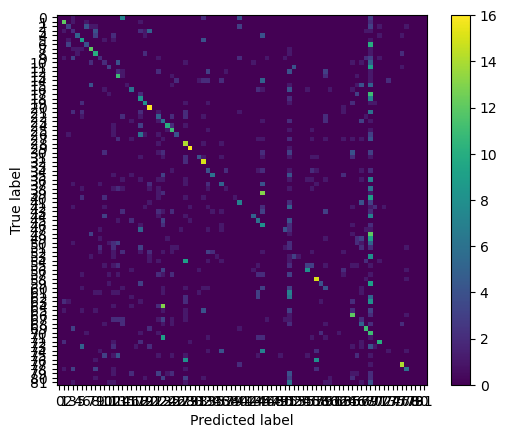

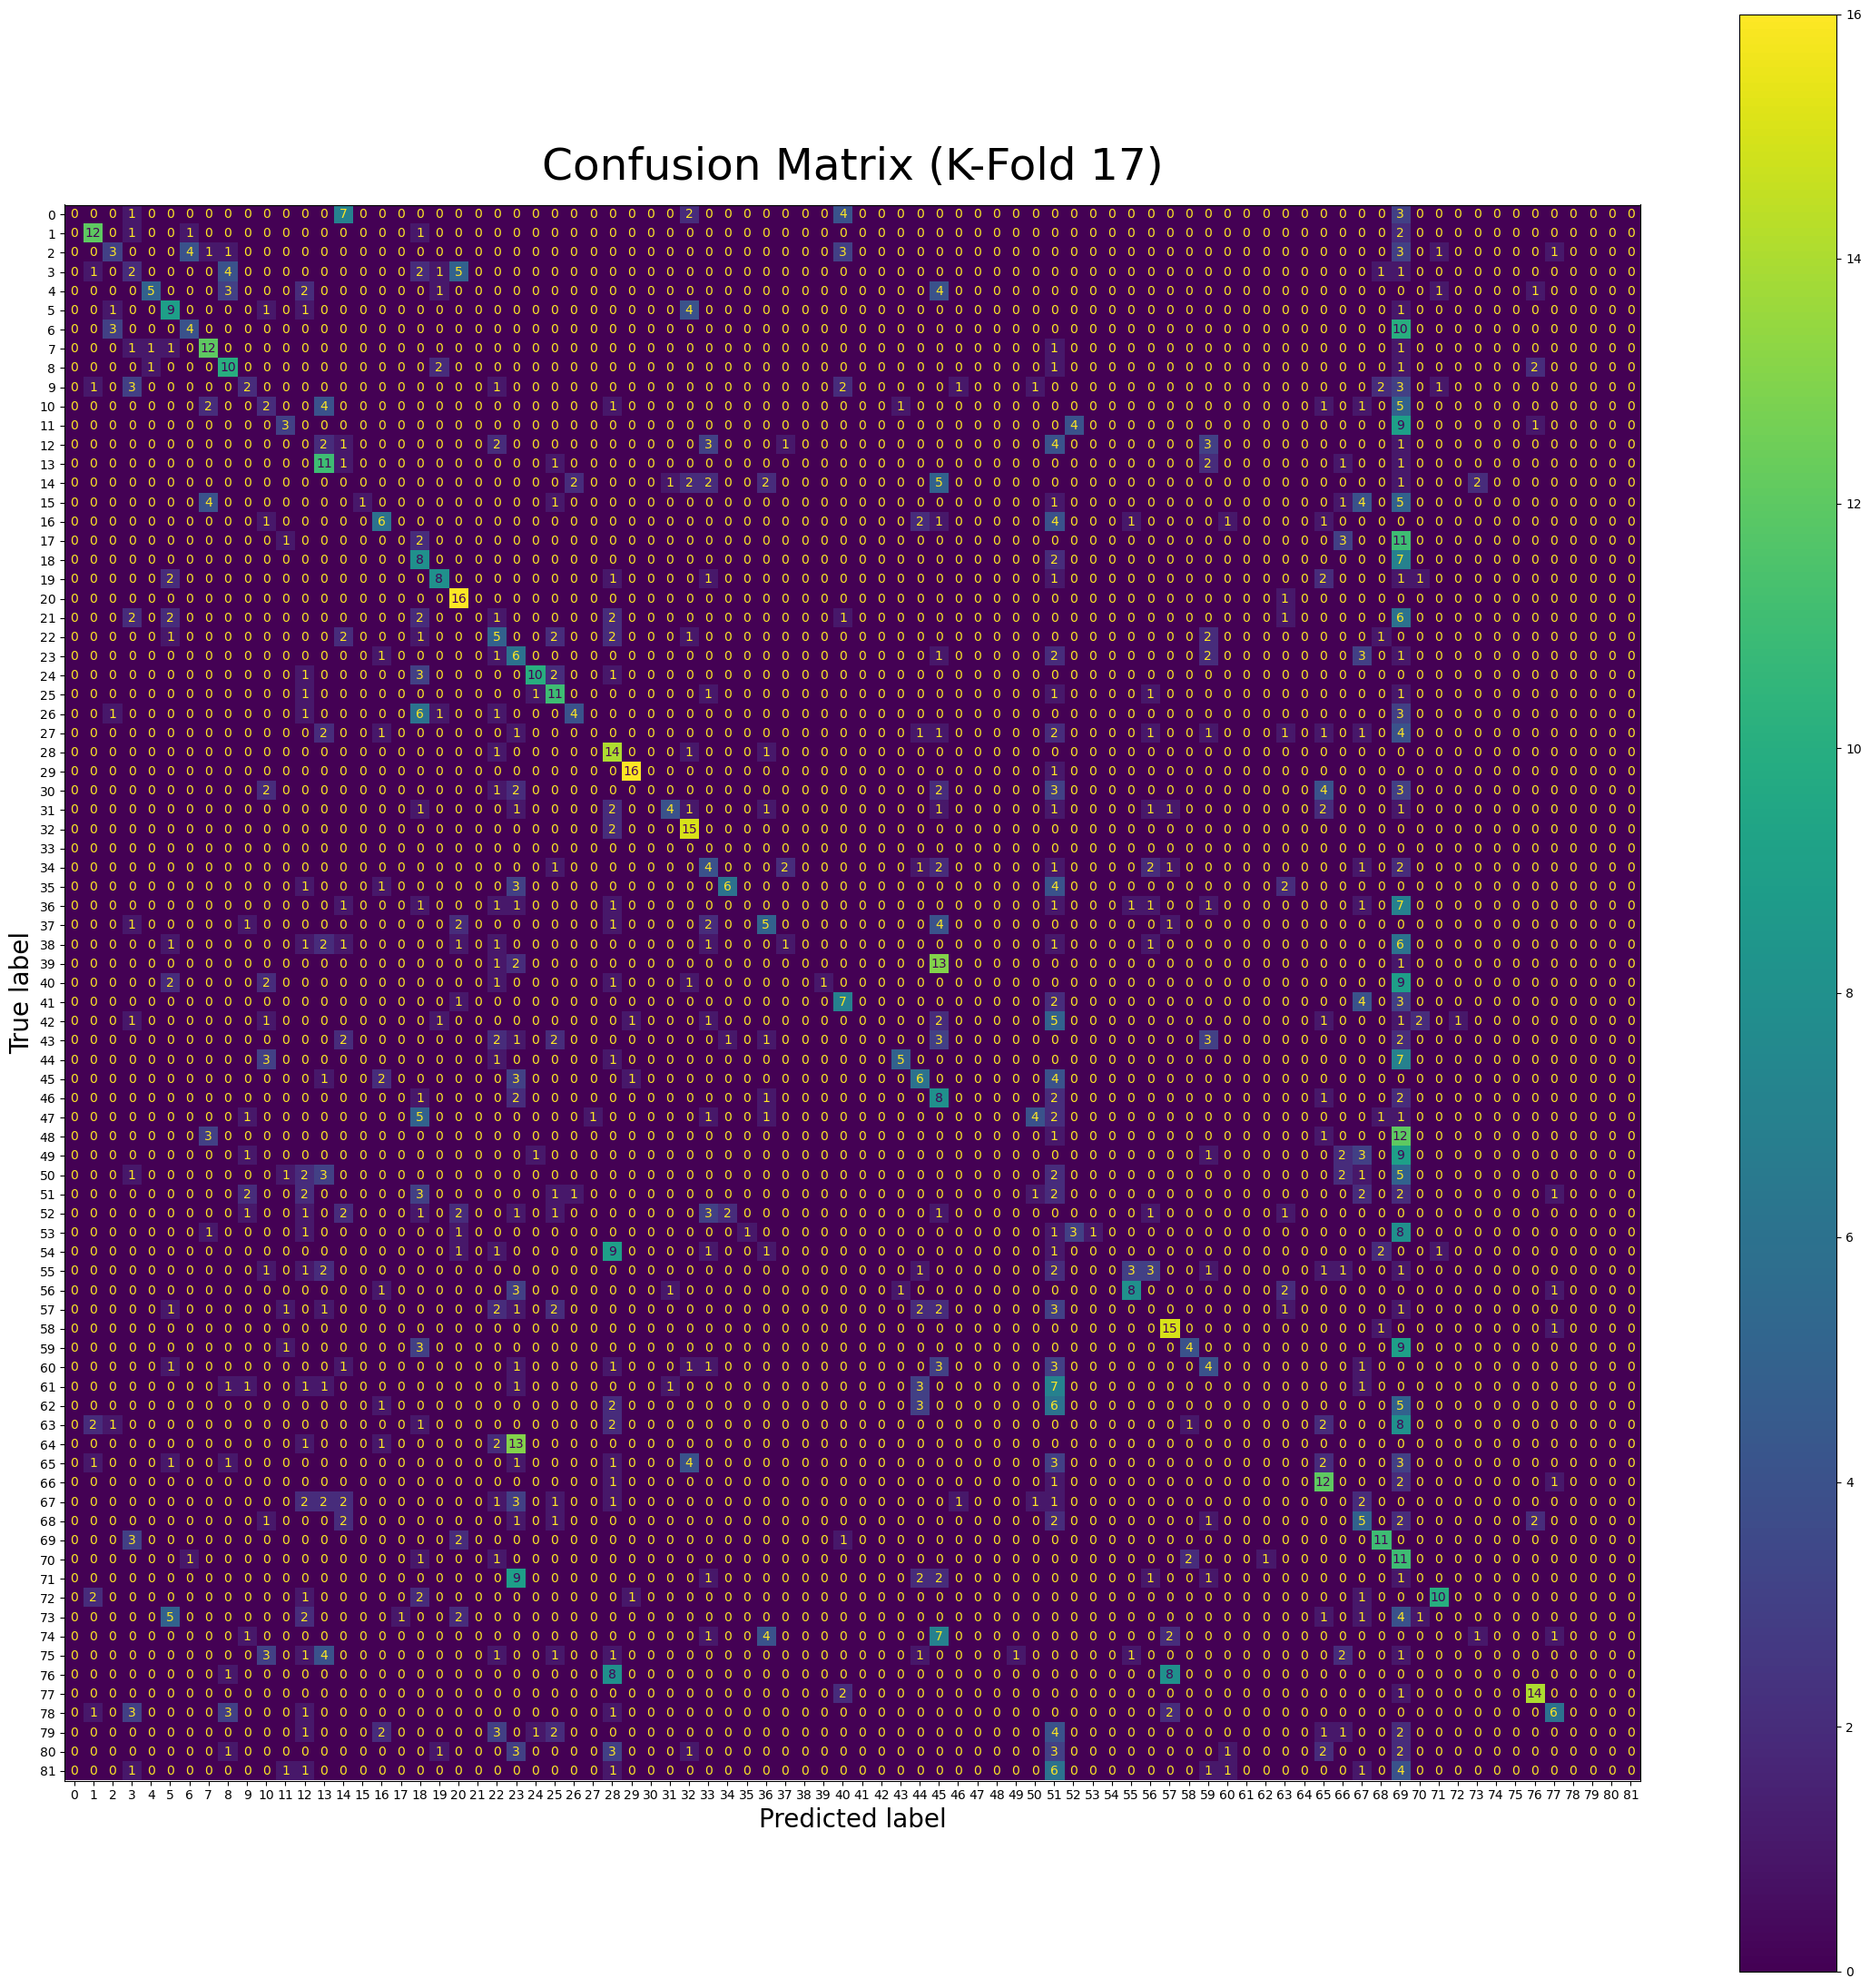

In [192]:
cmp = ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, include_values=False)
fig, ax = plt.subplots(figsize=(28,28))
ax.set_title("Confusion Matrix (K-Fold 17) MSCLAP",fontsize=35, pad=20)
ax.set_xlabel("Predicted Label", fontsize=20)
ax.set_ylabel("True Label",fontsize=20)
cmp.plot(ax=ax)

In [193]:
ucs_classes['int_to_class']["69"]

'trains'

In [112]:
mean_acc, mean_ap, pred, true = k_fold_zs_evaluation(k_fold_200_audio_embeddings_msclap, settings['k_fold_200-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)

print(f"Accuracy Score: {mean_acc}")
print(f"Average Precision Score: {mean_ap}")

100%|██████████| 200/200 [14:11<00:00,  4.26s/it]

Accuracy Score: 0.7103513770180447
Average Precision Score: 0.07717890083229098


In [12]:
k_folds = 200
n_tests = 200

total_acc = 0
total_ap = 0
for k in tqdm(range(k_folds)):
    df = pd.read_csv(f"D:/datasets/soundly/embeddings/zs_fold_{k+1}.csv")
    dataset = DatasetUCS(df, settings, device='cpu', return_type='path')
    label_embeddings_msclap = msclap_model.get_text_embeddings(dataset.get_unique_classes()).cpu()

    fold_acc_sum = 0
    fold_ap_sum = 0
    pred = []
    true = []
    for i in tqdm(range(n_tests)):
        sample_idx = random.randint(0, len(dataset)-1)
        path, label, class_name = dataset[sample_idx]

        audio_embeddings = audio_embeddings_msclap[k][sample_idx].cpu()
        similarities = torch.cosine_similarity(audio_embeddings, label_embeddings_msclap)
        #similarities = msclap_model.compute_similarity(audio_embeddings, label_embeddings)
        similarities = similarities.detach()
        probs = torch.softmax(similarities.unsqueeze(0), dim=1).detach().flatten() * 100
        idx = torch.argmax(probs)
        pred.append(idx.item())
        true.append(ucs_classes['class_to_int'][class_name])
        #indeces = torch.topk(probs, k=3).indices
        
    accuracy = accuracy_score(true, pred)
    total_acc += accuracy
    ap = average_precision_score(np.array(true).reshape(-1, 1), np.array(pred).reshape(-1, 1))
    total_ap += ap

print(f"Accuracy Score: {total_acc / k_folds}")
print(f"Average Precision Score: {total_ap / k_folds}")


100%|██████████| 200/200 [14:47<00:00,  4.44s/it]

Accuracy Score: 0.1807
Average Precision Score: 7.936507936507937e-05


In [68]:
fold_csv = [file for file in os.listdir(settings["k_fold_200-ground_truth"])]
fold_csv
#fold_csv.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
#print(fold_csv)

['zs_fold_1.csv',
 'zs_fold_10.csv',
 'zs_fold_100.csv',
 'zs_fold_101.csv',
 'zs_fold_102.csv',
 'zs_fold_103.csv',
 'zs_fold_104.csv',
 'zs_fold_105.csv',
 'zs_fold_106.csv',
 'zs_fold_107.csv',
 'zs_fold_108.csv',
 'zs_fold_109.csv',
 'zs_fold_11.csv',
 'zs_fold_110.csv',
 'zs_fold_111.csv',
 'zs_fold_112.csv',
 'zs_fold_113.csv',
 'zs_fold_114.csv',
 'zs_fold_115.csv',
 'zs_fold_116.csv',
 'zs_fold_117.csv',
 'zs_fold_118.csv',
 'zs_fold_119.csv',
 'zs_fold_12.csv',
 'zs_fold_120.csv',
 'zs_fold_121.csv',
 'zs_fold_122.csv',
 'zs_fold_123.csv',
 'zs_fold_124.csv',
 'zs_fold_125.csv',
 'zs_fold_126.csv',
 'zs_fold_127.csv',
 'zs_fold_128.csv',
 'zs_fold_129.csv',
 'zs_fold_13.csv',
 'zs_fold_130.csv',
 'zs_fold_131.csv',
 'zs_fold_132.csv',
 'zs_fold_133.csv',
 'zs_fold_134.csv',
 'zs_fold_135.csv',
 'zs_fold_136.csv',
 'zs_fold_137.csv',
 'zs_fold_138.csv',
 'zs_fold_139.csv',
 'zs_fold_14.csv',
 'zs_fold_140.csv',
 'zs_fold_141.csv',
 'zs_fold_142.csv',
 'zs_fold_143.csv',
 'zs_fo

TypeError: perform_evaluation() missing 2 required positional arguments: 'metrics' and 'test_set'